In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'spam-text-message-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2050%2F3494%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T130658Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6ce8cc0138761d2bbd965463ffca02cd16ca7192f3804700d380106a8ca444d38b3b06c83bb4a1b7e5a2ebad6989d7bd177698a76b1d5b19850fe464a3cdf7ed6482d2ba8c57c0d7bf7128e63d2e57f4842a4802b05114568b0872db6025a23653c31ae243a97ab05c9a29d5b2ac5c35428023aeff7c60d9b40ae65cd26dda77e5c30d313b62b9ef7fb71f56bb306ac2e269c62c42154643882d8e25beee000036e7e3253a04ec5af640d343fca2846d4eef6a3bd8d8acf7110f1d4633ecd42d6e9018c4d93a90855cacdf0a7b8d9e8b60461b09ed0f3fb77b4e8645bd76f3738e7c439cda57380643da0a2d1dfe0629347b6e62ca2049740b9e49dc33535923'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 213261 bytes downloaded
Downloaded and uncompressed: spam-text-message-classification
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv


In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import re
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn import metrics

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
from nltk import pos_tag
from nltk.corpus import wordnet

In [4]:
df1 = pd.read_csv("/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")

In [5]:
df1.shape

(5572, 2)

In [6]:
df1.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df1.groupby(['Category']).describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [9]:
df1.isnull().sum()

Category    0
Message     0
dtype: int64

In [10]:
#Since the database is big (5572) we are creating a subset database of 2700
df_ham = df1[df1["Category"]=="ham"][:2000]
df_spam = df1[df1["Category"]=="spam"][:700]
messeges = pd.concat([df_ham, df_spam])

In [11]:
messeges.shape

(2700, 2)

In [12]:
## cleaning the text

def cleantext(text):

    # removing the "\"

    text = re.sub("'\''","",text)

    # removing special symbols

    text = re.sub("[^a-zA-Z]"," ",text)

    # removing the whitespaces

    text = ' '.join(text.split())

    # convert text to lowercase

    text = text.lower()

    return text



messeges['Message'] = messeges['Message'].apply(lambda x:cleantext(x))
messeges['Message'].iloc[1]

'ok lar joking wif u oni'

In [13]:
!python -m nltk.downloader stopwords

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
# Install the stopwords corpus if it is not already installed
!python -m nltk.downloader stopwords

# Import the stopwords module
from nltk.corpus import stopwords

# Get a list of English stopwords
stopwords_list = stopwords.words('english')

# Print the list of stopwords
print(", ".join(stopwords_list))

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why

In [15]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:

def removestopwords(text):

    removedstopword = [word for word in text.split() if word not in stopwords_list]
    return ' '.join(removedstopword)

messeges['Message'] = messeges['Message'].apply(lambda x:removestopwords(x))
messeges['Message'].iloc[1]


'ok lar joking wif u oni'

In [18]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Removing numbers
def remove_numbers(text):
    pattern = r'\d+'
    text = re.sub(pattern, '', text)
    return text

In [19]:
messeges['Message']=messeges['Message'].apply(remove_special_characters)
messeges['Message']=messeges['Message'].apply(remove_numbers)

In [20]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [22]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

In [23]:
#lemmatizing

lemma=WordNetLemmatizer()

def lematizing(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = lemma.lemmatize(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


messeges['Message'] = messeges['Message'].apply(lambda x: lematizing(x))
messeges['Message'].iloc[1]

'ok lar joking wif u oni'

In [24]:
#stemming

# Approach

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming(sentence):

    stemmed_sentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemmed_sentence+=stem
        stemmed_sentence+=" "

    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

messeges['Message'] = messeges['Message'].apply(lambda text:stemming(text))
messeges['Message'].iloc[1]

'ok lar joke wif u oni'

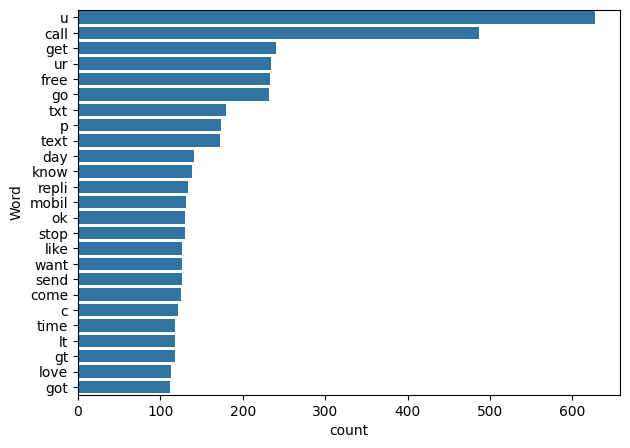

In [25]:
# visualising frewords

def showmostfrequentwords(text,no_of_words):

    allwords = ' '.join([char for char in text])
    allwords = allwords.split()
    fdist = nltk.FreqDist(allwords)

    wordsdf = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())})

    df = wordsdf.nlargest(columns="count",n = no_of_words)

    plt.figure(figsize=(7,5))
    ax = sn.barplot(data=df,x = 'count',y = 'word')
    ax.set(ylabel = 'Word')
    plt.show()

    return wordsdf


# 25 most frequent words


freq_df = showmostfrequentwords(messeges['Message'],25)


In [26]:
y = np.array(messeges['Category'].map({'ham': 1, 'spam': 0}))

# **VECTORIZATION**

# **bag of word**

In [53]:
## count vectorizer
import time
def vectorize_text():
    count_vec = CountVectorizer(max_df=0.90,min_df=2,
                           max_features=10000 )

    bagofword_vec = count_vec.fit_transform(messeges['Message'])
start_time = time.perf_counter()
# Perform vectorization
vector = vectorize_text()

# End time measurement
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Computational time for vectorization: {elapsed_time:.4f} seconds")

bagofword_vec

Computational time for vectorization: 0.2310 seconds


<2700x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 16742 stored elements in Compressed Sparse Row format>

In [31]:
## count vectorizer

count_vec = CountVectorizer(max_df=0.90,min_df=2,
                           max_features=1000,stop_words='english')

bagofword_vec = count_vec.fit_transform(messeges['Message'])
bagofword_vec

<2700x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 16742 stored elements in Compressed Sparse Row format>

In [32]:
X_train, X_test, y_train, y_test = train_test_split(bagofword_vec,y,
                                                    test_size=0.2)
X_train.shape,X_test.shape

((2160, 1000), (540, 1000))

# **SVC**

In [33]:
from sklearn import metrics
from sklearn.svm import SVC


# Train the SVC model
svc = SVC()
svc.fit(X_train, y_train)

# Make predictions on the test set
svccpred = svc.predict(X_test)

# Calculate accuracy on the training and test sets
train_accuracy = svc.score(X_train, y_train)
test_accuracy = svc.score(X_test, y_test)

# Print the accuracy scores
print('Accuracy on training data: {:,.3f}'.format(train_accuracy))
print('Accuracy on test data: {:,.3f}'.format(test_accuracy))

Accuracy on training data: 0.989
Accuracy on test data: 0.956


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y_test, svccpred))
print(classification_report(y_test, svccpred))

[[133  21]
 [  3 383]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       154
           1       0.95      0.99      0.97       386

    accuracy                           0.96       540
   macro avg       0.96      0.93      0.94       540
weighted avg       0.96      0.96      0.95       540



# ***MULTINOMIALNB***

In [35]:
mb = MultinomialNB()
mb.fit(X_train,y_train)
mbpred = mb.predict(X_test)
print(metrics.accuracy_score(y_test,mbpred))
print('Accuracy on training data: {:,.3f}'.format(mb.score (X_train, y_train)))

print('Accuracy on test data: {:,.3f}'.format(mb.score (X_test, y_test)))

0.95
Accuracy on training data: 0.978
Accuracy on test data: 0.950


In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y_test, mbpred))
print(classification_report(y_test, mbpred))

[[143  11]
 [ 16 370]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       154
           1       0.97      0.96      0.96       386

    accuracy                           0.95       540
   macro avg       0.94      0.94      0.94       540
weighted avg       0.95      0.95      0.95       540



# **LOGISTIC REGRESSION**

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Define the LogisticRegression model
log_reg = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the test data
model4_pred = log_reg.predict(X_test)

# Evaluate the accuracy of the model
print(metrics.accuracy_score(y_test, model4_pred))

print('Accuracy on training data: {:,.3f}'.format(log_reg.score (X_train, y_train)))

print('Accuracy on test data: {:,.3f}'.format(log_reg.score (X_test, y_test)))

0.9648148148148148
Accuracy on training data: 0.988
Accuracy on test data: 0.965


In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y_test, model4_pred))
print(classification_report(y_test, model4_pred))

[[136  18]
 [  1 385]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       154
           1       0.96      1.00      0.98       386

    accuracy                           0.96       540
   macro avg       0.97      0.94      0.96       540
weighted avg       0.97      0.96      0.96       540



# **NAIVE BAYERS**

In [39]:
#Naive Bayes Classifier

from sklearn.naive_bayes import GaussianNB

gnb= GaussianNB()

# Convert X_train to a dense NumPy array
X_train_dense = X_train.toarray()

# Convert X_test to a dense NumPy array
X_test_dense = X_test.toarray()

gnb.fit(X_train_dense,y_train)

gnbpred = gnb.predict(X_test_dense)

print(metrics.accuracy_score(y_test, gnbpred))

print('Accuracy on training data: {:,.3f}'.format(gnb.score (X_train_dense, y_train)))

print('Accuracy on test data: {:,.3f}'.format(gnb.score (X_test_dense, y_test)))

0.8
Accuracy on training data: 0.817
Accuracy on test data: 0.800


In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y_test, gnbpred))
print(classification_report(y_test, gnbpred))

[[146   8]
 [100 286]]
              precision    recall  f1-score   support

           0       0.59      0.95      0.73       154
           1       0.97      0.74      0.84       386

    accuracy                           0.80       540
   macro avg       0.78      0.84      0.79       540
weighted avg       0.86      0.80      0.81       540



# ** TF-IDF (Term Frequency-Inverse Document Frequency)**

In [41]:
import time
def vectorize_text():
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90,min_df=2,
                           max_features=10000)
    tfidf_vec = tfidf_vectorizer.fit_transform(messeges['Message'])

start_time = time.perf_counter()
# Perform vectorization
vector = vectorize_text()

# End time measurement
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Computational time for vectorization: {elapsed_time:.4f} seconds")

Computational time for vectorization: 0.0493 seconds


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

tfidf_matrix = tfidf_vec.fit_transform(messeges['Message'])
tfidf_matrix


<2700x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 16742 stored elements in Compressed Sparse Row format>

In [43]:
X2_train, X2_test, y2_train, y2_test = train_test_split(tfidf_matrix,y,
                                                    test_size=0.2)
X2_train.shape,X2_test.shape

((2160, 1000), (540, 1000))

# **SVC**

In [44]:
from sklearn import metrics
from sklearn.svm import SVC


# Train the SVC model
svc = SVC()
svc.fit(X2_train, y2_train)

# Make predictions on the test set
svccpred = svc.predict(X2_test)

# Calculate accuracy on the training and test sets
train_accuracy = svc.score(X2_train, y2_train)
test_accuracy = svc.score(X2_test, y2_test)

# Print the accuracy scores
print('Accuracy on training data: {:,.3f}'.format(train_accuracy))
print('Accuracy on test data: {:,.3f}'.format(test_accuracy))

Accuracy on training data: 0.995
Accuracy on test data: 0.961


In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y2_test, svccpred))
print(classification_report(y2_test, svccpred))

[[113  19]
 [  2 406]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       132
           1       0.96      1.00      0.97       408

    accuracy                           0.96       540
   macro avg       0.97      0.93      0.94       540
weighted avg       0.96      0.96      0.96       540



# **MULTINOMIALNB**

In [46]:
mb = MultinomialNB()
mb.fit(X2_train,y2_train)
mbpred = mb.predict(X2_test)
print(metrics.accuracy_score(y2_test,mbpred))
print('Accuracy on training data: {:,.3f}'.format(mb.score (X2_train, y2_train)))

print('Accuracy on test data: {:,.3f}'.format(mb.score (X2_test, y2_test)))

0.9629629629629629
Accuracy on training data: 0.977
Accuracy on test data: 0.963


In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y2_test, mbpred))
print(classification_report(y2_test, mbpred))

[[119  13]
 [  7 401]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       132
           1       0.97      0.98      0.98       408

    accuracy                           0.96       540
   macro avg       0.96      0.94      0.95       540
weighted avg       0.96      0.96      0.96       540



# **LOGISTIC REGRESSION**

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Define the LogisticRegression model
log_reg = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X2_train, y2_train)

# Make predictions on the test data
model4_pred = log_reg.predict(X2_test)

# Evaluate the accuracy of the model
print(metrics.accuracy_score(y2_test, model4_pred))

print('Accuracy on training data: {:,.3f}'.format(log_reg.score (X2_train, y2_train)))

print('Accuracy on test data: {:,.3f}'.format(log_reg.score (X2_test, y2_test)))

0.95
Accuracy on training data: 0.969
Accuracy on test data: 0.950


In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y2_test, model4_pred))
print(classification_report(y2_test, model4_pred))

[[108  24]
 [  3 405]]
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       132
           1       0.94      0.99      0.97       408

    accuracy                           0.95       540
   macro avg       0.96      0.91      0.93       540
weighted avg       0.95      0.95      0.95       540



# **NAIVE BAYERS**

In [50]:
#Naive Bayes Classifier

from sklearn.naive_bayes import GaussianNB

gnb= GaussianNB()

# Convert X_train to a dense NumPy array
X2_train_dense = X2_train.toarray()

# Convert X_test to a dense NumPy array
X2_test_dense = X2_test.toarray()

gnb.fit(X2_train_dense,y2_train)

gnbpred = gnb.predict(X2_test_dense)

print(metrics.accuracy_score(y2_test, gnbpred))

print('Accuracy on training data: {:,.3f}'.format(gnb.score (X2_train_dense, y2_train)))

print('Accuracy on test data: {:,.3f}'.format(gnb.score (X2_test_dense, y2_test)))

0.8166666666666667
Accuracy on training data: 0.856
Accuracy on test data: 0.817


In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y2_test, gnbpred))
print(classification_report(y2_test, gnbpred))

[[122  10]
 [ 89 319]]
              precision    recall  f1-score   support

           0       0.58      0.92      0.71       132
           1       0.97      0.78      0.87       408

    accuracy                           0.82       540
   macro avg       0.77      0.85      0.79       540
weighted avg       0.87      0.82      0.83       540



In [52]:
## count vectorizer
import time
def vectorize_text():
    count_vec = CountVectorizer(max_df=0.90,min_df=2,
                           max_features=10000 )

    bagofword_vec = count_vec.fit_transform(messeges['Message'])
start_time = time.perf_counter()
# Perform vectorization
vector = vectorize_text()

# End time measurement
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Computational time for vectorization: {elapsed_time:.4f} seconds")

bagofword_vec

Computational time for vectorization: 0.0544 seconds


<2700x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 16742 stored elements in Compressed Sparse Row format>

In [57]:
!pip install word2vec
import word2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 829.2 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=141242 sha256=5c93e62fd89a02c923ff273cc2f2273287133a2a4b955432ca69501838cf7594
  Stored in directory: /root/.cache/pip/wheels/6a/fa/d1/e03e8c10e0e2aa5c7b6e2b46b4a1c715d140283853937bb4b1
Successfully built word2vec


In [73]:
import nltk

In [74]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **WORD2VEC**

In [78]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import pandas as pd
import time
def vectorize_text():
  # Tokenize the preprocessed messages
  tokenized_messages = messeges['Message'].apply(word_tokenize)
  w2v_model = Word2Vec(sentences=tokenized_messages, vector_size=100, window=5, min_count=2, sg=1)
  def get_average_word2vec(tokens_list, model):
    word_vectors = []
    for word in tokens_list:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if word_vectors:
        message_vector = sum(word_vectors) / len(word_vectors)
    else:
        message_vector = [0] * model.vector_size
    return message_vector

# Vectorize text using Word2Vec embeddings
    word2vec_vectors = tokenized_messages.apply(lambda x: get_average_word2vec(x, w2v_model))


# Print the shape of the resulting embeddings
start_time = time.perf_counter()
# Perform vectorization
vector = vectorize_text()

# End time measurement
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Computational time for vectorization: {elapsed_time:.4f} seconds")


Computational time for vectorization: 0.7867 seconds


In [85]:
from sklearn.feature_extraction.text import *

In [86]:
!pip install sklearn-extras

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn-extras: filename=sklearn_extras-0.1.1-py3-none-any.whl size=2181 sha256=948a96c55cddec3fb72b48bfea61c1acc074c4c364ee02ee4e86ed5246ccdcc4
  Stored in directory: /root/.cache/pip/wheels/17/be/14/4e60423bc56c67eb57f37be00fd7b6fe32876e57ce884b1412
Successfully built sklearn-extras


In [100]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Assuming `messages` is a DataFrame containing text messages in the column 'Message'

# Define the preprocess_function
def preprocess_function(text):
    # Replace this with your actual preprocessing steps
    # Preprocess the text messages
    messeges['Message'] = messeges['Message'].apply(preprocess_function)
    return text.lower()



# Tokenize the preprocessed messages
tokenized_messages = messeges['Message'].apply(word_tokenize)

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_messages, vector_size=100, window=5, min_count=2, sg=0)

# Example usage to get Word2Vec embeddings for a specific word
word = 'example_word'
if word in w2v_model.wv:
    word_vector = w2v_model.wv[word]
    print(f"Word vector for '{word}': {word_vector}")

# Example usage to get Word2Vec embeddings for a specific text message
def get_average_word2vec(tokens_list, model):
    word_vectors = []
    for word in tokens_list:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if word_vectors:
        message_vector = sum(word_vectors) / len(word_vectors)
    else:
        message_vector = [0] * model.vector_size
    return message_vector

# Vectorize text using Word2Vec embeddings
word2vec_vectors = tokenized_messages.apply(lambda x: get_average_word2vec(x, w2v_model))

# Convert the Word2Vec vectors into a matrix
word2vec_matrix = pd.DataFrame(word2vec_vectors.tolist())

# Print the Word2Vec matrix

word2vec_matrix

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.143531,0.221924,-0.007294,0.009838,0.036996,-0.305273,0.062427,0.445421,-0.111865,-0.059748,...,0.302519,0.072737,-0.033113,0.094150,0.321885,0.252072,0.082850,-0.208205,0.085955,-0.073371
1,-0.131702,0.197425,-0.004352,0.010849,0.034617,-0.275039,0.052193,0.399570,-0.105787,-0.051947,...,0.269552,0.063768,-0.027247,0.085524,0.286406,0.222988,0.071149,-0.187371,0.076064,-0.060424
2,-0.234041,0.365282,-0.010568,0.021598,0.062249,-0.510441,0.099062,0.741895,-0.195088,-0.097174,...,0.495792,0.119524,-0.058793,0.160967,0.535439,0.420030,0.133715,-0.347641,0.138803,-0.121014
3,-0.146956,0.221438,-0.003842,0.009566,0.033775,-0.312037,0.059476,0.446102,-0.115446,-0.060257,...,0.305406,0.073508,-0.037389,0.092626,0.325803,0.254575,0.080161,-0.210584,0.086433,-0.073023
4,-0.148545,0.221735,-0.007187,0.014584,0.035109,-0.312218,0.057894,0.451153,-0.119483,-0.057806,...,0.302335,0.073154,-0.037829,0.092746,0.320621,0.257303,0.086740,-0.204077,0.089775,-0.071738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,-0.094514,0.143331,-0.006114,0.008568,0.026582,-0.196548,0.038665,0.290624,-0.076008,-0.037531,...,0.198509,0.048385,-0.021899,0.058987,0.207525,0.162365,0.051743,-0.134595,0.052838,-0.046508
2696,-0.194849,0.294356,-0.008613,0.015087,0.050957,-0.410976,0.079108,0.603090,-0.155224,-0.082688,...,0.405412,0.094524,-0.041911,0.123302,0.433896,0.344460,0.108809,-0.282397,0.112356,-0.098068
2697,-0.173040,0.257408,-0.008038,0.011530,0.045799,-0.359696,0.071181,0.527453,-0.135175,-0.070353,...,0.357791,0.083013,-0.035060,0.111705,0.380225,0.299677,0.095476,-0.243223,0.099242,-0.085662
2698,-0.112692,0.167952,-0.002377,0.012161,0.029900,-0.237405,0.045734,0.346255,-0.088965,-0.046738,...,0.234865,0.053225,-0.025189,0.072149,0.250772,0.196247,0.062211,-0.163792,0.062810,-0.056634


In [95]:
!pip install gensim

In [101]:
X3_train, X3_test, y3_train, y3_test = train_test_split(word2vec_matrix,y,
                                                    test_size=0.2)
X3_train.shape,X3_test.shape

((2160, 100), (540, 100))

# **SVC**

In [102]:
from sklearn import metrics
from sklearn.svm import SVC


# Train the SVC model
svc = SVC()
svc.fit(X3_train, y3_train)

# Make predictions on the test set
svccpred = svc.predict(X3_test)

# Calculate accuracy on the training and test sets
train_accuracy = svc.score(X3_train, y3_train)
test_accuracy = svc.score(X3_test, y3_test)

# Print the accuracy scores
print('Accuracy on training data: {:,.3f}'.format(train_accuracy))
print('Accuracy on test data: {:,.3f}'.format(test_accuracy))

Accuracy on training data: 0.743
Accuracy on test data: 0.733


In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y3_test, svccpred))
print(classification_report(y3_test, svccpred))

[[  0 144]
 [  0 396]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       144
           1       0.73      1.00      0.85       396

    accuracy                           0.73       540
   macro avg       0.37      0.50      0.42       540
weighted avg       0.54      0.73      0.62       540



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **LOGISTIC REGRESSION**

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Define the LogisticRegression model
log_reg = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X3_train, y3_train)

# Make predictions on the test data
model4_pred = log_reg.predict(X3_test)

# Evaluate the accuracy of the model
print(metrics.accuracy_score(y3_test, model4_pred))

print('Accuracy on training data: {:,.3f}'.format(log_reg.score (X3_train, y3_train)))

print('Accuracy on test data: {:,.3f}'.format(log_reg.score (X3_test, y3_test)))

0.7314814814814815
Accuracy on training data: 0.743
Accuracy on test data: 0.731


In [109]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y3_test, model4_pred))
print(classification_report(y3_test, model4_pred))

[[  0 144]
 [  1 395]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       144
           1       0.73      1.00      0.84       396

    accuracy                           0.73       540
   macro avg       0.37      0.50      0.42       540
weighted avg       0.54      0.73      0.62       540



# **NAIVE BAYERS**

In [111]:
!pip install scikit-learn

In [114]:
# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn import metrics

# Load your data into X3_train, X3_test, y3_train, y3_test variables

# Create a Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Convert DataFrame objects to NumPy arrays
X3_train_dense = X3_train.values
X3_test_dense = X3_test.values

# Train the classifier
gnb.fit(X3_train_dense, y3_train)

# Predict the labels for the test data
gnbpred = gnb.predict(X3_test_dense)

# Calculate and print the accuracy score
print(f"Accuracy score: {metrics.accuracy_score(y3_test, gnbpred)}")

# Calculate and print the training data accuracy
print(f"Accuracy on training data: {gnb.score(X3_train_dense, y3_train):.3f}")

# Calculate and print the test data accuracy
print(f"Accuracy on test data: {gnb.score(X3_test_dense, y3_test):.3f}")

Accuracy score: 0.5111111111111111
Accuracy on training data: 0.546
Accuracy on test data: 0.511


In [115]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y3_test, gnbpred))
print(classification_report(y3_test, gnbpred))

[[120  24]
 [240 156]]
              precision    recall  f1-score   support

           0       0.33      0.83      0.48       144
           1       0.87      0.39      0.54       396

    accuracy                           0.51       540
   macro avg       0.60      0.61      0.51       540
weighted avg       0.72      0.51      0.52       540

